In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Loading the Data
directory = "/kaggle/input/crime-cast-forecasting-crime-categories/"
train = directory + "train.csv"
test = directory + "test.csv"
sample = directory + "sample.csv"

df = pd.read_csv(train)
validation = pd.read_csv(test)
samp = pd.read_csv(sample)
df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [3]:
df.shape #shape of train.csv

(20000, 22)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

#### 7 columns contain null values.
#### Cross_Street especially has above 80% as null values.
#### Weapon_Used_Code and Weapon_Description has above 60% as null values.
#### other 4 columns containing null values relatively have lesser null values.

In [5]:
df.columns

Index(['Location', 'Cross_Street', 'Latitude', 'Longitude', 'Date_Reported',
       'Date_Occurred', 'Time_Occurred', 'Area_ID', 'Area_Name',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


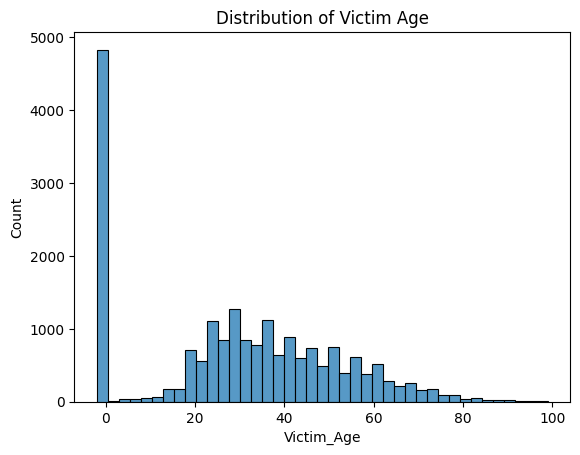

In [6]:
sns.histplot(df['Victim_Age'])
plt.title('Distribution of Victim Age')
plt.show()

### There seems to be ages less than 0 that are not possible

In [7]:
impossible_ages = (df['Victim_Age'] <= 0).sum()
"Impossible age count",impossible_ages

('Impossible age count', 4834)

In [8]:
percentage_impossible = impossible_ages / df.shape[0] * 100
percentage_impossible.round(2)

24.17

### This is a big issue as almost 25% of Victim_Age row is obviously false
### we can try to replace it with median

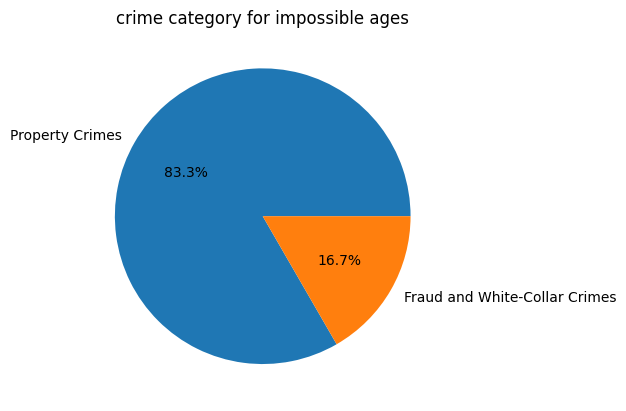

In [9]:
impossible_age_df = df[df['Victim_Age'] < 0]

target_relation_impossible = impossible_age_df['Crime_Category'].value_counts()
plt.pie(target_relation_impossible, labels=target_relation_impossible.index, autopct='%1.1f%%')
plt.title('crime category for impossible ages')
plt.show()

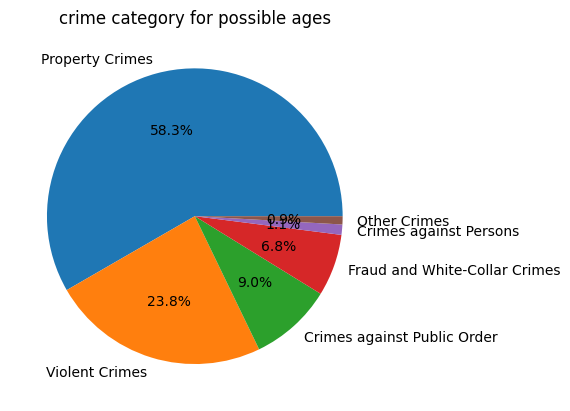

In [10]:
target_relation_possible = df['Crime_Category'].value_counts()
plt.pie(target_relation_possible, labels=target_relation_possible.index, autopct='%1.1f%%')
plt.title('crime category for possible ages')
plt.show()

### more than 50% of crime category is Property Crimes
### 
### Let's now try to include more features out of the existing ones. They might turn out to be crucial to the prediction

In [11]:
df['Time_Occurred'].min(), df['Time_Occurred'].max()

(1.0, 2359.0)

### It is in railway time

In [12]:
df['Part 1-2'].value_counts()

Part 1-2
1.0    11637
2.0     8363
Name: count, dtype: int64

In [13]:
df['Cross_Street'].value_counts()

Cross_Street
BROADWAY                           56
FIGUEROA                           43
VERMONT                      AV    40
FIGUEROA                     ST    34
MAIN                               33
                                   ..
VENTURA CANYON               BL     1
E  ORLANDO                          1
D                            ST     1
CABRILLO                     AV     1
HAVELOCK                            1
Name: count, Length: 1495, dtype: int64

In [14]:
def feature_eng(df):
    def time_change(time):
        hour = time // 100
        if 0 <= hour < 6:
            return 'Night'
        elif 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        return 'Evening'

    median_age = df[df['Victim_Age'] > 0]['Victim_Age'].median()
    df.loc[df['Victim_Age'] <= 0, 'Victim_Age'] = median_age

    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format="%m/%d/%Y %I:%M:%S %p")
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'], format="%m/%d/%Y %I:%M:%S %p")
    df['Days_Taken'] = (df['Date_Reported'] - df['Date_Occurred']).dt.days

    df['Day_Occurred'] = (pd.to_datetime(df['Date_Occurred'])).dt.day
    df['WeekDay_Occurred'] = (pd.to_datetime(df['Date_Occurred'])).dt.weekday
    df['Month_Occurred'] = (pd.to_datetime(df['Date_Occurred'])).dt.month
    df['Day_Reported'] = (pd.to_datetime(df['Date_Reported'])).dt.day
    df['WeekDay_Reported'] = (pd.to_datetime(df['Date_Reported'])).dt.weekday
    df['Month_Reported'] = (pd.to_datetime(df['Date_Reported'])).dt.month


    df['Time_Of_Day'] = df['Time_Occurred'].apply(time_change)
    df['Hour_Occurred'] = df['Time_Occurred'].apply(lambda x : x // 100)
    df['Modus_Operandi'] = df['Modus_Operandi'].apply(lambda x : len(x.split()) if type(x) == type('a') else np.NaN)

    df.drop(columns=['Time_Occurred','Date_Reported','Date_Occurred'],inplace=True)
    return df

1111
4555 5555 5555
"1111 4555"

In [15]:
df = feature_eng(df)
df.head()

,Location,Cross_Street,Latitude,Longitude,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,...,Crime_Category,Days_Taken,Day_Occurred,WeekDay_Occurred,Month_Occurred,Day_Reported,WeekDay_Reported,Month_Reported,Time_Of_Day,Hour_Occurred
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,15.0,N Hollywood,1563.0,1.0,1.0,75.0,...,Property Crimes,3,6,4,3,9,0,3,Evening,18.0
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,13.0,Newton,1367.0,1.0,8.0,41.0,...,Property Crimes,0,27,3,2,27,3,2,Afternoon,13.0
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,13.0,Newton,1343.0,2.0,2.0,67.0,...,Property Crimes,0,21,4,8,21,4,8,Morning,6.0
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,19.0,Mission,1924.0,1.0,2.0,61.0,...,Property Crimes,2,6,4,11,8,6,11,Evening,18.0
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,12.0,77th Street,1245.0,1.0,6.0,37.0,...,Property Crimes,0,25,1,2,25,1,2,Morning,11.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Area_ID                20000 non-null  float64
 5   Area_Name              20000 non-null  object 
 6   Reporting_District_no  20000 non-null  float64
 7   Part 1-2               20000 non-null  float64
 8   Modus_Operandi         17259 non-null  float64
 9   Victim_Age             20000 non-null  float64
 10  Victim_Sex             17376 non-null  object 
 11  Victim_Descent         17376 non-null  object 
 12  Premise_Code           20000 non-null  float64
 13  Premise_Description    19995 non-null  object 
 14  Weapon_Used_Code       7335 non-null   float64
 15  We

In [17]:
X = df.drop('Crime_Category', axis=1)
y = df['Crime_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)

In [18]:
categorical_features = list(X.select_dtypes(include='object').columns)
numerical_features = list(X.select_dtypes(include=['int64', 'float64']).columns)

### Baseline Model:

In [19]:
base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Score from Baseline Model: ",score)

Score from Baseline Model:  0.58075


In [20]:
# Pre-processing data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

### KNN:

In [21]:
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])
params = {
    'classifier__n_neighbors': [3, 5, 8, 10, 20]
}

In [22]:
%%time
grid_search_knn = GridSearchCV(knn_pipeline, params, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

CPU times: user 14min 20s, sys: 672 ms, total: 14min 20s
Wall time: 3min 56s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Modus_Operandi',
                                                                          'Victim_Age',
                                                                          'Premise_Code',
                                                                          'Weapon_Used_Code',
                                                                          'Days_Taken',
                                                                          'Hour_Occurred']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'Cross_Street',
                                                                          'Area_Name',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Weapon_Description',
                                                                          'Status',
                                                                          'Status_Description',
                                                                          'Time_Of_Day'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 5, 8, 10, 20]},
             scoring='accuracy')

In [23]:
y_pred = grid_search_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("KNN")
print("Accuracy: ",accuracy)
print("Best \'n_neighbors\': ",grid_search_knn.best_params_['classifier__n_neighbors'])

KNN
Accuracy:  0.78225
Best 'n_neighbors':  20


In [24]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       1.00      0.08      0.14        39
  Crimes against Public Order       0.71      0.34      0.46       364
Fraud and White-Collar Crimes       0.57      0.76      0.65       285
                 Other Crimes       0.00      0.00      0.00        33
              Property Crimes       0.86      0.91      0.89      2323
               Violent Crimes       0.68      0.69      0.68       956

                     accuracy                           0.78      4000
                    macro avg       0.64      0.46      0.47      4000
                 weighted avg       0.78      0.78      0.77      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM:

In [25]:
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=63))
])
params = {
    "classifier__kernel" : ['rbf', 'sigmoid']
}

In [26]:
%%time
grid_search_svm = GridSearchCV(svm_pipeline, params, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

CPU times: user 2min 11s, sys: 1.17 s, total: 2min 12s
Wall time: 2min 12s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Modus_Operandi',
                                                                          'Victim_Age',
                                                                          'Premise_Code',
                                                                          'Weapon_Used_Code',
                                                                          'Days_Taken',
                                                                          'Hour_Occurred']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'Cross_Street',
                                                                          'Area_Name',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Weapon_Description',
                                                                          'Status',
                                                                          'Status_Description',
                                                                          'Time_Of_Day'])])),
                                       ('classifier', SVC(random_state=63))]),
             param_grid={'classifier__kernel': ['rbf', 'sigmoid']},
             scoring='accuracy')

In [27]:
y_pred = grid_search_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM")
print("Accuracy: ",accuracy)
print("Best \'kernel\': ",grid_search_svm.best_params_['classifier__kernel'])

SVM
Accuracy:  0.8575
Best 'kernel':  rbf


In [28]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.67      0.31      0.42        39
  Crimes against Public Order       0.76      0.45      0.57       364
Fraud and White-Collar Crimes       0.65      0.86      0.74       285
                 Other Crimes       0.00      0.00      0.00        33
              Property Crimes       0.93      0.93      0.93      2323
               Violent Crimes       0.80      0.90      0.85       956

                     accuracy                           0.86      4000
                    macro avg       0.64      0.57      0.58      4000
                 weighted avg       0.85      0.86      0.85      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree:

In [29]:
decision_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=63))
])
params = {
    'classifier__criterion' : ['gini','entropy'],
    'classifier__max_depth': [None, 10, 22]
}

In [30]:
%%time
grid_search_decision = GridSearchCV(decision_pipeline, params, cv=5, scoring='accuracy')
grid_search_decision.fit(X_train, y_train)

CPU times: user 29.7 s, sys: 6.1 ms, total: 29.7 s
Wall time: 29.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Modus_Operandi',
                                                                          'Victim_Age',
                                                                          'Premise_Code',
                                                                          'Weapon_Used_Code',
                                                                          'Days_Taken',
                                                                          'Hour_Occurred']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'Cross_Street',
                                                                          'Area_Name',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Weapon_Description',
                                                                          'Status',
                                                                          'Status_Description',
                                                                          'Time_Of_Day'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=63))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 22]},
             scoring='accuracy')

In [31]:
y_pred = grid_search_decision.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree")
print("Accuracy: ",accuracy)
print("Best \'criterion\': ",grid_search_decision.best_params_['classifier__criterion'])
print("Best \'max_depth\': ",grid_search_decision.best_params_['classifier__max_depth'])

Decision Tree
Accuracy:  0.86125
Best 'criterion':  gini
Best 'max_depth':  10


In [32]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.64      0.54      0.58        39
  Crimes against Public Order       0.62      0.64      0.63       364
Fraud and White-Collar Crimes       0.79      0.74      0.76       285
                 Other Crimes       0.00      0.00      0.00        33
              Property Crimes       0.92      0.93      0.92      2323
               Violent Crimes       0.85      0.87      0.86       956

                     accuracy                           0.86      4000
                    macro avg       0.64      0.62      0.63      4000
                 weighted avg       0.85      0.86      0.86      4000



### Bagging:

In [33]:
bag_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(random_state=63))
])
params = {
    'classifier__n_estimators': [5, 10, 20]
}

In [34]:
%%time
grid_search_bag = GridSearchCV(bag_pipeline, params, cv=5, scoring='accuracy')
grid_search_bag.fit(X_train, y_train)

CPU times: user 2min 40s, sys: 27.5 ms, total: 2min 40s
Wall time: 2min 40s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Modus_Operandi',
                                                                          'Victim_Age',
                                                                          'Premise_Code',
                                                                          'Weapon_Used_Code',
                                                                          'Days_Taken',
                                                                          'Hour_Occurred']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'Cross_Street',
                                                                          'Area_Name',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Weapon_Description',
                                                                          'Status',
                                                                          'Status_Description',
                                                                          'Time_Of_Day'])])),
                                       ('classifier',
                                        BaggingClassifier(random_state=63))]),
             param_grid={'classifier__n_estimators': [5, 10, 20]},
             scoring='accuracy')

In [35]:
y_pred = grid_search_bag.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Bagging")
print("Accuracy: ",accuracy)
print("Best \'n_estimators\': ", grid_search_bag.best_params_['classifier__n_estimators'])

Bagging
Accuracy:  0.872
Best 'n_estimators':  20


In [36]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.63      0.62      0.62        39
  Crimes against Public Order       0.70      0.60      0.65       364
Fraud and White-Collar Crimes       0.80      0.79      0.79       285
                 Other Crimes       0.60      0.09      0.16        33
              Property Crimes       0.92      0.93      0.92      2323
               Violent Crimes       0.85      0.89      0.87       956

                     accuracy                           0.87      4000
                    macro avg       0.75      0.65      0.67      4000
                 weighted avg       0.87      0.87      0.87      4000



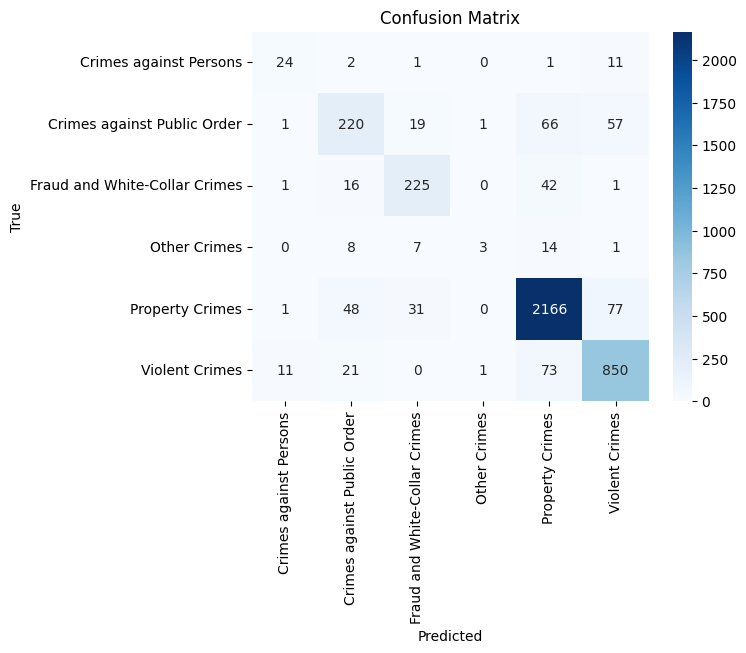

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Boosting:

In [38]:
boost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=63))
])
params = {
    'classifier__learning_rate' : [0.01, 0.1, 0.3],
    'classifier__n_estimators': [5, 10, 20]
} 

In [39]:
%%time
grid_search_boost = GridSearchCV(boost_pipeline, params, cv=5, scoring='accuracy')
grid_search_boost.fit(X_train, y_train)

CPU times: user 3min 11s, sys: 32.5 ms, total: 3min 11s
Wall time: 3min 11s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Area_ID',
                                                                          'Reporting_District_no',
                                                                          'Part '
                                                                          '1-2',
                                                                          'Modus_Operandi',
                                                                          'Victim_Age',
                                                                          'Premise_Code',
                                                                          'Weapon_Used_Code',
                                                                          'Days_Taken',
                                                                          'Hour_Occurred']),
                                                                        ('cat',
                                                                         Pipel...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'Cross_Street',
                                                                          'Area_Name',
                                                                          'Victim_Sex',
                                                                          'Victim_Descent',
                                                                          'Premise_Description',
                                                                          'Weapon_Description',
                                                                          'Status',
                                                                          'Status_Description',
                                                                          'Time_Of_Day'])])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=63))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.3],
                         'classifier__n_estimators': [5, 10, 20]},
             scoring='accuracy')

In [40]:
y_pred = grid_search_boost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Boosting")
print("Accuracy: ",accuracy)
print("Best \'learning_rate\': ", grid_search_boost.best_params_['classifier__learning_rate'])
print("Best \'n_estimators\': ", grid_search_boost.best_params_['classifier__n_estimators'])

Boosting
Accuracy:  0.86775
Best 'learning_rate':  0.3
Best 'n_estimators':  10


In [41]:
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.56      0.64      0.60        39
  Crimes against Public Order       0.71      0.55      0.62       364
Fraud and White-Collar Crimes       0.81      0.74      0.77       285
                 Other Crimes       0.00      0.00      0.00        33
              Property Crimes       0.92      0.92      0.92      2323
               Violent Crimes       0.82      0.93      0.88       956

                     accuracy                           0.87      4000
                    macro avg       0.64      0.63      0.63      4000
                 weighted avg       0.86      0.87      0.86      4000



### Bagging Classifier seems to have the highest accuracy out of the trained models. So we will use it for prediction of test.csv.

In [42]:
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        random_state=63,
        n_estimators=grid_search_bag.best_params_['classifier__n_estimators']
    ))
])

In [43]:
%%time
best_pipeline.fit(X,y) #Using all rows of training data

CPU times: user 31.1 s, sys: 7.06 ms, total: 31.1 s
Wall time: 31.1 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Area_ID',
                                                   'Reporting_District_no',
                                                   'Part 1-2', 'Modus_Operandi',
                                                   'Victim_Age', 'Premise_Code',
                                                   'Weapon_Used_Code',
                                                   'Days_Taken',
                                                   'Hour_Occurred']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location', 'Cross_Street',
                                                   'Area_Name', 'Victim_Sex',
                                                   'Victim_Descent',
                                                   'Premise_Description',
                                                   'Weapon_Description',
                                                   'Status',
                                                   'Status_Description',
                                                   'Time_Of_Day'])])),
                ('classifier',
                 BaggingClassifier(n_estimators=20, random_state=63))])

In [44]:
y_validation = best_pipeline.predict(feature_eng(validation))
y_validation

array(['Violent Crimes', 'Property Crimes', 'Property Crimes', ...,
       'Violent Crimes', 'Violent Crimes', 'Property Crimes'],
      dtype=object)

In [45]:
samp.head()

,ID,Crime_Category,Unnamed: 2
0,1,Crimes against Persons,NaN
1,2,Crimes against Public Order,NaN
2,3,Other Crimes,NaN
3,4,Crimes against Public Order,NaN
4,5,Other Crimes,NaN


In [46]:
final_df = pd.DataFrame({
    "ID" : [i+1 for i in range(len(y_validation))],
    "Crime_Category" : y_validation,
})
final_df.head()

,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Property Crimes
3,4,Property Crimes
4,5,Crimes against Public Order


In [47]:
final_df.to_csv('prediction.csv',index=False)